<h1>Potential pitfalls of feature selection with high-dimensional data</h1>

In this notebook we will explore how having many features increases the chances of finding signal in noise. Feature selection can actually increase the possibility that you might "distill" a "signal" and happen across some effective-looking models even when working with data that have been generated at random.

<h4>Loading packages and defining a couple of functions</h4>

In [2]:
library(dplyr)
library(Boruta)
library(ggplot2)
library(caret)
library(tidyr)
call.do <- function(args, what){do.call(what, args)}
plot.window <- function(x, y){
    options(repr.plot.width = x, repr.plot.height = y, repr.plot.res = 100)
}

<h4>These functions from my (RKOpTris) useful-funs and r-class-tools repositories on GitHub. They are to split the dataset into trai, test and holdout sets, and then to write as objects into the global environment</h4>

In [3]:
tth_split <- function(df, var = NULL, test_prop = 0.15, holdout_prop = 0.15, shuffle_train = F){
  stopifnot(is.numeric(test_prop), test_prop >= 0.05, holdout_prop <= test_prop, is.numeric(holdout_prop))
  if(!is.null(var)){
    tth_split <- split(df, df[[var]])
  } else {
    tth_split <- list(df)
  }
  train_prop <- 1 - test_prop - holdout_prop
  tth_data <- lapply(tth_split, function(df){
    df$.TTH <- sample(c("train", "test", "holdout"), nrow(df), replace = T, prob = c(train_prop, test_prop, holdout_prop))
    df
  })
  tth_data <- do.call(rbind, tth_data)
  row.names(tth_data) <- 1:nrow(tth_data)
  tth_data <- tth_data %>% split(tth_data$.TTH)
  tth_data <- lapply(tth_data, function(df){df$.TTH <- NULL; df})
  if(shuffle_train){
    tth_data$train[[var]] <- shuffle(tth_data$train[[var]])
  }
  tth_data
}

list_to_objects <- function(x, suffix = NULL, envir = parent.env(environment())){
  stopifnot(is.list(x) | is.environment(envir))
  if(is.null(names(x))){
    names(x) <- paste0("X", 1:length(x))
  } 
  list_names <- names(x)
  if(!is.null(suffix)){
    object_names <- paste0(suffix, "_", list_names)
  } else {
    object_names <- list_names
  }
  for(i in 1:length(x)){
    assign(object_names[i], x[[list_names[i]]], envir = envir)
    message(object_names[i], " created")
  }
}

<h4>Generate random dataset and separate observations (randomly) into two classes (a and b) which will be used to train a random forest model</h4>

In [4]:
nObservation <- 2^6
nFeature <- 2^10
set.seed(1138)
randomData <- lapply(1:nObservation, function(i){runif(nFeature)}) %>% call.do(rbind) %>% data.frame()
nGroup <- 2
classSize <- nObservation / nGroup
randomData <- randomData %>% mutate(group = rep(letters[1:nGroup], each = classSize))
dim(randomData)

[1]   64 1025

<h4>Split data into train, test and holdout sets for random forest</h4>

In [5]:
tth_split(randomData, "group") %>% list_to_objects()
head(train)

holdback created
test created
train created


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1016,X1017,X1018,X1019,X1020,X1021,X1022,X1023,X1024,group
1,0.2735481,0.1658198,0.2716583,0.59671162,0.6689339,0.47903286,0.53462407,0.9021131,0.2794055,0.81010312,...,0.59936817,0.40161776,0.75901258,0.01027292,0.1420067,0.567931393,0.2251452,0.2794025,0.001682388,a
2,0.4369064,0.2624905,0.5173542,0.84487795,0.7948039,0.17687608,0.90222333,0.3681251,0.1220852,0.36096901,...,0.07580692,0.08328123,0.09615077,0.05752478,0.8723098,0.339875903,0.2504070,0.4939295,0.509679762,a
4,0.9805419,0.1242287,0.5751676,0.07271604,0.6763298,0.30267699,0.86821552,0.7064075,0.6812734,0.76650626,...,0.07258728,0.67698065,0.57424622,0.37587236,0.5659434,0.642358562,0.9803297,0.1986621,0.166158764,a
6,0.1516652,0.9135941,0.2806793,0.98765521,0.8341834,0.08730391,0.09749321,0.9924669,0.3992429,0.23050736,...,0.26820880,0.93047142,0.02388089,0.89538908,0.6274444,0.146701076,0.9860405,0.5730885,0.136443190,a
7,0.9415527,0.5875131,0.8116554,0.59386725,0.2158728,0.52846828,0.86244734,0.4014504,0.1643136,0.89367783,...,0.74079801,0.86602918,0.80806014,0.78082153,0.2225391,0.017228276,0.6162191,0.2606054,0.510471286,a
8,0.2219987,0.1485699,0.4536769,0.47694581,0.7954455,0.04507450,0.76660145,0.8217877,0.2482733,0.04420001,...,0.17687233,0.81537920,0.16013135,0.33402010,0.2477387,0.005409186,0.8383730,0.4582069,0.905461462,a


<h4>We'll do some feature selection on the random features we've created in this random dataset. Boruta, our feature selection algorithm can take a while. You can always load the dataset a couple of lines below. It is running 10 times so be patient! Here we're using the default value of 0.01</h4>

In [29]:
# randomBoruta <- vector("list", 10)
# for(i in 1:length(randomBoruta)){
#     randomBoruta[[i]] <- Boruta(select(train, -group), as.factor(train$group), maxRuns = 500, doTrace = 0, pValue = 0.01)
# }

In [30]:
# saveRDS(randomBoruta, "randomBoruta.RDS")

In [6]:
randomBoruta <- readRDS("randomBoruta.RDS")

<h4>In the last notebook about chance patterns in data, we explored the possibility that the more features we have increases the possibility of some features containing signal from the noise that might show as significant in a statistical test. We have used the Boruta algorithm and an alpha level of significance of 0.01. We have 1024 features and so we might expect that ~10 might be significant. In this particaulr randomly generated dataset Boruta, after 10 runs, found and average of ~7. The results are plottied in a histogram.</h4> 

[1] "Potential number of significant features"


[1] 10.24

[1] "Number of important features identified by Boruta in each run"


[1] 11  8  6  4  5  7  7  5  7  6

[1] "Mean number of important features identified by Boruta for all runs"


[1] 6.6

Warning message:
"Column `value` joining factors with different levels, coercing to character vector"

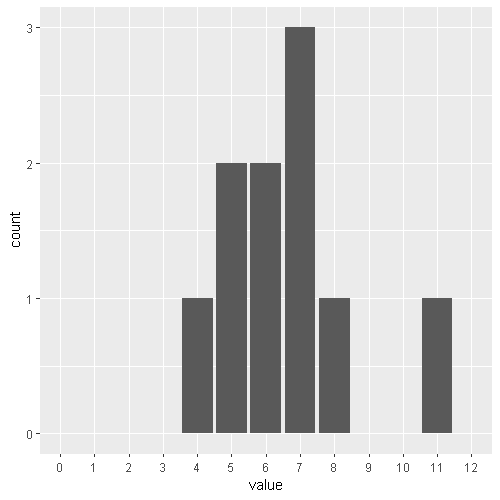

In [7]:
print("Potential number of significant features")
(numPotential <- 0.01 * nFeature)

print("Number of important features identified by Boruta in each run")
(numImportant <- sapply(randomBoruta, function(x){sum(x$finalDecision == "Confirmed")}))

print("Mean number of important features identified by Boruta for all runs")
mean(numImportant)

plot.window(5, 5)
data.frame(table(numImportant)) %>% 
    rename("value" = "numImportant", "count" = "Freq") %>%
    right_join(data.frame(value = as.factor(0:12)), by = "value") %>%
    replace(is.na(.), 0) %>%
    mutate(value = factor(value, levels = as.character(0:12))) %>%
    ggplot(aes(x = value, y = count)) +
    geom_col()

<h4>Now let's see the difference between training a random forest model on all of the data, versus a model trained on the data containing only the (randomly) important features. On all the data accuracy generally was about chance, but Kappa was low. The best result (mtry = 2, splitrule = gini) was accuracy = 0.65, Kappa = 0.29 (which is about the threshold for whether a model is performing well).</h4>

In [8]:
# Run classification on complete data
rf_mod <- caret::train(group ~ ., train,
                       method = "ranger",
                       trControl = trainControl(method = "cv",
                                                number = 3,
                                                returnData = F))
rf_mod

Random Forest 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 30, 32, 30 
Resampling results across tuning parameters:

  mtry  splitrule   Accuracy   Kappa      
     2  gini        0.6458333   0.29166667
     2  extratrees  0.5238095   0.04761905
    45  gini        0.3988095  -0.20238095
    45  extratrees  0.5000000   0.00000000
  1024  gini        0.4315476  -0.13690476
  1024  extratrees  0.4136905  -0.17261905

Tuning parameter 'min.node.size' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 2, splitrule = gini
 and min.node.size = 1.

<h4>Here we have the important features in our dataset of random values.</h4>

notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.
notch went outside hinges. Try setting notch=FALSE.


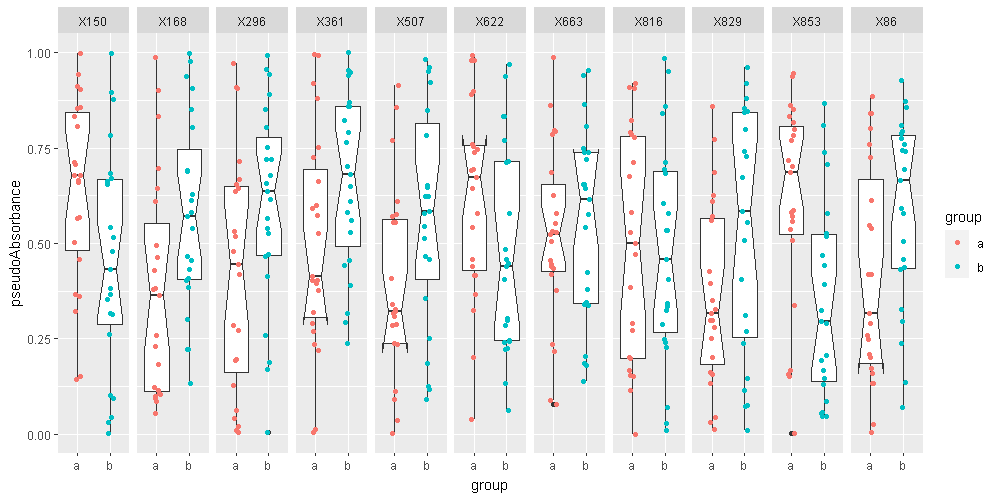

In [11]:
fs_train <- train[randomBoruta[[1]]$finalDecision == "Confirmed"]
fs_train <- fs_train %>% mutate(group = train$group)

plot.window(10, 5)
fs_train %>% 
    gather("pseudoWavenumber", "pseudoAbsorbance", -group) %>%
    ggplot(aes(group, pseudoAbsorbance)) +
    geom_boxplot(notch = T) +
    geom_jitter(width = 0.1, aes(col = group)) +
    facet_wrap(~pseudoWavenumber, nrow = 1)

<h4>If we feature select just those "important" features and train a random forest model, we get up to accuracy = 0.85 and Kappa = 0.7 (mtry = 2, splitrule = extratrees) which would be considered a very effective model. This is randomly generated data, remember. We kept aside test and holdout sets to further validate the model. Let's see what we get...</h4>

In [12]:
# Run classification on Boruta important features
fs_mod <- caret::train(group ~ ., fs_train,
                       method = "ranger",
                       trControl = trainControl(method = "cv",
                                                number = 3,
                                                returnData = F))
fs_mod

Random Forest 

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 30, 31, 31 
Resampling results across tuning parameters:

  mtry  splitrule   Accuracy   Kappa    
   2    gini        0.7375000  0.4743362
   2    extratrees  0.8458333  0.6951552
   6    gini        0.7388889  0.4753647
   6    extratrees  0.7597222  0.5194236
  11    gini        0.7375000  0.4743362
  11    extratrees  0.6958333  0.3940276

Tuning parameter 'min.node.size' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were mtry = 2, splitrule = extratrees
 and min.node.size = 1.

<h4>The test set produced an accuracy of 0.75! Not an amazing model, but one that is achieving much better than chance (0.5 as its a binary classifier)</h4>

In [13]:
print("Test accuracy:")
mean(predict(fs_mod, test) == test$group) %>% round(3)

[1] "Test accuracy:"


[1] 0.75

<h4>The predicted values of the holdout set were not so good, but still better-than-chance.</h4>

In [16]:
print("Holdout accuracy:")
mean(predict(fs_mod, holdback) == holdback$group) %>% round(3)

[1] "Holdout accuracy:"


[1] 0.667

Here we have seen how signal can be discovered in a randomly generated dataset and yield good classification metrics. The results are obviously false in that the data were random and this result means nothing, but it demonstrates that "signals" can be found and may produce convincing results.

A bit of doubt cast on the model comes from the fact that the holdout accuracy was markedly worse than the test accuracy and for it to be unstable like that should cause the investigator to at least scratch their head.
    
Being that it is possible that chance patterns can occur in noise, and those patterns are more likely to occur in line with the number of features that are in our data, it is particularly important to scrutinise models and investigate the variable importance to see if it makes sense. <b>We need to use our subject knowledge.</b>
    
In spectra we have many variables (wavenumbers) and therefore a good chance there will be some patterns that feature selection and traditional machine learning algorithms can find. In the next notebook we will look at assessing variable importance in the context of spectra.